# **Preprocessing of Data**

In [ ]:
# # uncomment and install if you don't have the libraries installed
%pip install simpletransformers
%pip install optuna kaleido
# %pip install tensorboardx

In [6]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from imblearn.over_sampling import SMOTEN

In [7]:
import torch
import transformers
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, RandomApply, RandomHorizontalFlip, RandomRotation
from torch.distributions import Normal
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import logging
from collections import Counter
from ast import literal_eval
from imblearn.over_sampling import SMOTEN

import transformers
from tqdm import tqdm   
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")

In [9]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [10]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [11]:
# we dont need this anymore as I have modified the file which also gives us processed data for test set
# module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
# module_name = module_url.split('/')[-1]
# print(f'Fetching {module_url}')
# #with open("file_1.txt") as f1, open("file_2.txt") as f2
# with request.urlopen(module_url) as f, open(module_name,'w') as outf:
#   a = f.read()
#   outf.write(a.decode('utf-8'))
import os
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer

class DontPatronizeMe:

	def __init__(self, train_path, test_path):

		self.train_path = train_path
		self.test_path = test_path
		self.train_task1_df = None
		self.train_task2_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels. 
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(os.path.join(self.train_path, 'dontpatronizeme_pcl.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		self.train_task1_df = df

	def load_task2(self, return_one_hot=True):
		# Reads the data for task 2 and present it as paragraphs with binarized labels (a list with seven positions, "activated or not (1 or 0)",
		# depending on wether the category is present in the paragraph).
		# It returns a pandas dataframe with paragraphs and list of binarized labels.
		tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
		print('Map of label to numerical label:')
		print(tag2id)
		data = defaultdict(list)
		with open (os.path.join(self.train_path, 'dontpatronizeme_categories.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				text=line.split('\t')[2]#.lower()
				keyword=line.split('\t')[3]
				country=line.split('\t')[4]
				start=line.split('\t')[5]
				finish=line.split('\t')[6]
				text_span=line.split('\t')[7]
				label=line.strip().split('\t')[-2]
				num_annotators=line.strip().split('\t')[-1]
				labelid = tag2id[label]
				if not labelid in data[(par_id, art_id, text, keyword, country)]:
					data[(par_id,art_id, text, keyword, country)].append(labelid)

		par_ids=[]
		art_ids=[]
		pars=[]
		keywords=[]
		countries=[]
		labels=[]

		for par_id, art_id, par, kw, co in data.keys():
			par_ids.append(par_id)
			art_ids.append(art_id)
			pars.append(par)
			keywords.append(kw)
			countries.append(co)

		for label in data.values():
			labels.append(label)

		if return_one_hot:
			labels = MultiLabelBinarizer().fit_transform(labels)
		df = pd.DataFrame(list(zip(par_ids, 
									art_ids, 
									pars, 
									keywords,
									countries, 
									labels)), columns=['par_id',
														'art_id', 
														'text', 
														'keyword',
														'country', 
														'label',
														])
		self.train_task2_df = df


	def load_test(self):
		#self.test_df = [line.strip() for line in open(self.test_path)]
		rows=[]
		with open(self.test_path) as f:
			for line in f:
				t=line.strip().split('\t')
				rows.append(t)
		self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())
		#drop the art_id,country columns
		self.test_set_df = self.test_set_df.drop(['art_id','country'], axis=1)
		#rename keyword to community
		self.test_set_df = self.test_set_df.rename(columns={'keyword':'community'})

In [12]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [13]:
dpm = DontPatronizeMe(r'/kaggle/input/nlp-cw', r'/kaggle/input/nlp-cw/task4_test.tsv') # train and test paths
dpm.load_task1() # load task 1 training set
dpm.load_test() # load test set

In [14]:
print(dpm.train_task1_df.shape) #train and dev set, train needs to be split into train and dev(for internal evaluation)
print(dpm.test_set_df.shape) #official test set

(10469, 7)
(3832, 3)


In [15]:
allData = dpm.train_task1_df # load training data
allData.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0


In [16]:
trainIDs = pd.read_csv(r'/kaggle/input/nlp-cw/train_semeval_parids-labels.csv')
devIDS = pd.read_csv(r'/kaggle/input/nlp-cw/dev_semeval_parids-labels.csv')
trainIDs.par_id = trainIDs.par_id.astype(str)
devIDS.par_id = devIDS.par_id.astype(str)

In [17]:
# building the trainSet
rows = [] # will contain par_id, label and text
for idx in range(len(trainIDs)):  
  parid = trainIDs.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = allData.loc[allData.par_id == parid].keyword.values[0]
  text = allData.loc[allData.par_id == parid].text.values[0]
  label = allData.loc[allData.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

In [18]:
trainData = pd.DataFrame(rows)
trainData.head()

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1


In [19]:
rows = [] # will contain par_id, label and text
for idx in range(len(devIDS)):  
  parid = devIDS.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = allData.loc[allData.par_id == parid].keyword.values[0]
  text = allData.loc[allData.par_id == parid].text.values[0]
  label = allData.loc[allData.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

In [20]:
devData = pd.DataFrame(rows)
devData.head()

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1


In [21]:
testData = dpm.test_set_df
testData.head()

,par_id,community,text
0,t_0,vulnerable,"In the meantime , conservatives are working to..."
1,t_1,women,In most poor households with no education chil...
2,t_2,migrant,The real question is not whether immigration i...
3,t_3,migrant,"In total , the country 's immigrant population..."
4,t_4,vulnerable,"Members of the church , which is part of Ken C..."


In [22]:
trainData.shape

(8375, 4)

In [23]:
# upsampling the minority class
from imblearn.over_sampling import SMOTENC

def upSampling(trainingDataPrime):
    cat_features = [1, 2]
    smote_nc = SMOTENC(categorical_features=cat_features, random_state=42)
    localDataX = trainingDataPrime
    localDataY = trainingDataPrime.label
    localDataX = localDataX.drop('label', axis=1)
    X_resampled, y_resampled = smote_nc.fit_resample(localDataX, localDataY)

    # create a new balanced dataset from the resampled data
    trainingDataPrime = pd.concat([X_resampled, y_resampled], axis=1)
    print(len(trainingDataPrime[trainingDataPrime.label==1]))
    print(len(trainingDataPrime[trainingDataPrime.label==0]))
    print(trainingDataPrime.shape)
    return trainingDataPrime

In [38]:

# dataX = downSample(trainData)
trainDataPrime = upSampling(trainData)

7581
7581
(15162, 4)


In [41]:
def train_and_evaluate(trial):
    print('Starting training...')

    # Define the hyperparameters to tune
    LR = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 4e-5])
    TRAIN_BATCH_SIZE = trial.suggest_categorical('batch_size',[8,16,32])
    MAX_SEQ_LEN = trial.suggest_categorical('maxlen', [64, 128, 256])
    WEIGHT_DECAY = trial.suggest_categorical('weight_decay', [0,0.1])
    OPTIMIZER = trial.suggest_categorical('optimizer', ['AdamW'])

    print('learning_rate: ', LR, 'batch_size: ', TRAIN_BATCH_SIZE, 'weight_decay',WEIGHT_DECAY,'max length: ', MAX_SEQ_LEN, 'optimizer: ', OPTIMIZER)

    trainingData, validationData = train_test_split(trainDataPrime, test_size=0.2, random_state=42)
    print(trainingData.shape,validationData.shape)

    EPOCHS = 2
    NUM_LABELS = 2
    MODEL_TYPE = 'roberta'
    MODEL_NAME = 'roberta-base'

    roberta_baseline_model_args = ClassificationArgs(num_train_epochs=EPOCHS,
                                    no_save=True, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    learning_rate = LR,
                                    weight_decay=WEIGHT_DECAY,
                                    train_batch_size = TRAIN_BATCH_SIZE,
                                    max_seq_length = MAX_SEQ_LEN, 
                                    optimizer = OPTIMIZER)
        
    roberta_baseline_model = ClassificationModel(MODEL_TYPE, 
                                    MODEL_NAME, 
                                    args = roberta_baseline_model_args, 
                                    num_labels=NUM_LABELS, 
                                    use_cuda=cuda_available)
    
    print("model created..")
    roberta_baseline_model.train_model(trainingData[['text', 'label']], eval_df=validationData[['text', 'label']])
    # roberta_baseline_model.train_model(trainingDataPrime[['text', 'label']])

    print('Model Trained!')
    # run predictions
    # preds_roberta_baseline_model_official_dev, _ = roberta_baseline_model.predict(validationData.text.values.tolist())
    val_results, _ = roberta_baseline_model.predict(validationData.text.values.tolist())

    # score = f1_score(devData.label.values, preds_roberta_baseline_model_official_dev, average='binary',pos_label=1)
    score = f1_score(validationData.label.values, val_results, average='binary',pos_label=1)
    # accuracy = (preds_roberta_baseline_model_official_dev == devData.label.values).mean()
    accuracy = (val_results == validationData.label.values).mean()
    
    print('--------------------------------------------------')
    print('F1 Score: ', score)
    print('Accuracy: ', accuracy)
    print('--------------------------------------------------')

    return score

In [42]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(train_and_evaluate, n_trials=10)

print('Best hyperparameters: ', study.best_params)
print('Best F1 score achieved: ', study.best_value)

[I 2023-03-05 23:30:39,165] A new study created in memory with name: no-name-1d896454-4dae-475d-bb7b-eae9a7440654


Starting training...
learning_rate:  4e-05 batch_size:  16 weight_decay 0.1 max length:  64 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-05 23:34:03,630] Trial 0 finished with value: 0.9762532981530343 and parameters: {'learning_rate': 4e-05, 'batch_size': 16, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.9762532981530343.


--------------------------------------------------
F1 Score:  0.9762532981530343
Accuracy:  0.9762611275964391
--------------------------------------------------
Starting training...
learning_rate:  4e-05 batch_size:  32 weight_decay 0 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/380 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/380 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-05 23:40:27,178] Trial 1 finished with value: 0.9730085582620146 and parameters: {'learning_rate': 4e-05, 'batch_size': 32, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.9762532981530343.


--------------------------------------------------
F1 Score:  0.9730085582620146
Accuracy:  0.9729640619848335
--------------------------------------------------
Starting training...
learning_rate:  4e-05 batch_size:  8 weight_decay 0 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-05 23:50:02,005] Trial 2 finished with value: 0.9784554192906861 and parameters: {'learning_rate': 4e-05, 'batch_size': 8, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.9784554192906861
Accuracy:  0.9785690735245631
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  8 weight_decay 0 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-05 23:59:37,406] Trial 3 finished with value: 0.9574537187398506 and parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.9574537187398506
Accuracy:  0.9568084404879658
--------------------------------------------------
Starting training...
learning_rate:  4e-05 batch_size:  16 weight_decay 0.1 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:07:07,393] Trial 4 finished with value: 0.9717105263157895 and parameters: {'learning_rate': 4e-05, 'batch_size': 16, 'maxlen': 256, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.9717105263157895
Accuracy:  0.9716452357401912
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  32 weight_decay 0.1 max length:  64 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/380 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/380 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:09:27,449] Trial 5 finished with value: 0.9430318635339556 and parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.9430318635339556
Accuracy:  0.9416419386745796
--------------------------------------------------
Starting training...
learning_rate:  0.0001 batch_size:  16 weight_decay 0 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:16:56,165] Trial 6 finished with value: 0.6579646017699115 and parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.6579646017699115
Accuracy:  0.49027365644576326
--------------------------------------------------
Starting training...
learning_rate:  0.0001 batch_size:  16 weight_decay 0.1 max length:  64 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/759 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:20:20,688] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.0
Accuracy:  0.5097263435542367
--------------------------------------------------
Starting training...
learning_rate:  0.0001 batch_size:  8 weight_decay 0.1 max length:  256 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:29:56,319] Trial 8 finished with value: 0.6579646017699115 and parameters: {'learning_rate': 0.0001, 'batch_size': 8, 'maxlen': 256, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.6579646017699115
Accuracy:  0.49027365644576326
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  8 weight_decay 0.1 max length:  128 optimizer:  AdamW
(12129, 4) (3033, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/12129 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1517 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/3033 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

[I 2023-03-06 00:36:38,520] Trial 9 finished with value: 0.9544270833333334 and parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'maxlen': 128, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9784554192906861.


--------------------------------------------------
F1 Score:  0.9544270833333334
Accuracy:  0.9538410814375206
--------------------------------------------------
Best hyperparameters:  {'learning_rate': 4e-05, 'batch_size': 8, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}
Best F1 score achieved:  0.9784554192906861


In [113]:
hist_fig = optuna.visualization.plot_optimization_history(study)
param_imp_fig = optuna.visualization.plot_param_importances(study)
parallel_info_fig = optuna.visualization.plot_parallel_coordinate(study, params=['learning_rate','batch_size','maxlen', 'weight_decay'])

In [114]:
# parallel_info_fig = optuna.visualization.plot_parallel_coordinate(study,line_alpha=0.5, params=['learning_rate','batch_size','maxlen', 'weight_decay'] )
parallel_info_fig.update_layout(title_text="",font_size=18)

# lines = parallel_info_fig.data[0].line.colorscale
# print(lines)
# parallel_info_fig.data[0].line.colorscale = ((0.0, 'rgb(247,251,255)'), (0.125, 'rgb(222,235,247)'), (0.25, 'rgb(198,219,239)'), (0.375, 'rgb(158,202,225)'), (0.5, 'rgb(107,174,214)'), (0.625, 'rgb(66,146,198)'), (0.75, 'rgb(33,113,181)'), (0.875, 'rgb(255,255,0)'), (1.0, 'rgb(255,0,0)'))

parallel_info_fig
# optuna.visualization.plot_parallel_coordinate(line)

In [ ]:
hist_fig.data[0].color='green'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



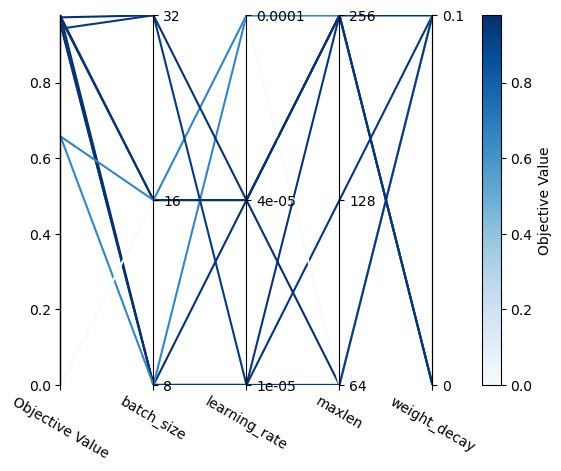

In [116]:
plot = optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['learning_rate','batch_size','maxlen', 'weight_decay'])
plot.title.set_text('')
# plot.savefig("sans.png")

In [117]:
hist_fig.write_image('./hist_img_val.pdf')
param_imp_fig.write_image("./param_imp_val.pdf")
parallel_info_fig.write_image("./parallel_info_val.pdf")

In [106]:
# Define the hyperparameters to tune
LR = 4e-05
TRAIN_BATCH_SIZE = 8
MAX_SEQ_LEN = 256
WEIGHT_DECAY = 0

print('learning_rate: ', LR, 'batch_size: ', TRAIN_BATCH_SIZE, 'weight_decay',WEIGHT_DECAY,'max length: ', MAX_SEQ_LEN)

# Load the data
#     trainData, devData = load_data()
trainingData, validationData = train_test_split(trainDataPrime, test_size=0.1, random_state=42)
print(trainingData.shape,validationData.shape)

EPOCHS = 1
NUM_LABELS = 2
MODEL_TYPE = 'roberta'
MODEL_NAME = 'roberta-base'

roberta_baseline_model_args = ClassificationArgs(num_train_epochs=EPOCHS,
                                no_save=True, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                learning_rate=LR,
                                weight_decay=WEIGHT_DECAY,
                                train_batch_size=TRAIN_BATCH_SIZE,
                                max_seq_length=MAX_SEQ_LEN)

roberta_baseline_model = ClassificationModel(MODEL_TYPE, 
                                MODEL_NAME, 
                                args = roberta_baseline_model_args, 
                                num_labels=NUM_LABELS, 
                                use_cuda=cuda_available)

print("model created..")
roberta_baseline_model.train_model(trainingData[['text', 'label']], eval_df=validationData[['text', 'label']])
# roberta_baseline_model.train_model(trainingDataPrime[['text', 'label']])

print('Model Trained!')
# run predictions
preds_roberta_baseline_model_official_dev, _ = roberta_baseline_model.predict(devData.text.values.tolist())
# val_results, _ = roberta_baseline_model.predict(validationData.text.values.tolist())

score = f1_score(devData.label.values, preds_roberta_baseline_model_official_dev, average='binary',pos_label=1)
# score = f1_score(validationData.label.values, val_results, average='binary',pos_label=1)
accuracy = (preds_roberta_baseline_model_official_dev == devData.label.values).mean()
# accuracy = (val_results == validationData.label.values).mean()

print('--------------------------------------------------')
print('F1 Score: ', score)
print('Accuracy: ', accuracy)
print('--------------------------------------------------')

learning_rate:  4e-05 batch_size:  8 weight_decay 0 max length:  256
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1706 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

--------------------------------------------------
F1 Score:  0.48811410459587956
Accuracy:  0.8457497612225406
--------------------------------------------------


In [36]:
# Evaluate the model
result, model_outputs = roberta_baseline_model.predict(validationData.text.values.tolist())

  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

In [37]:
result

array([0, 1, 0, ..., 1, 1, 0])

In [31]:
preds_roberta_baseline_model_official_dev

array([0, 1, 0, ..., 0, 0, 0])

In [22]:
def train_and_evaluate(trial):
    print('Starting training...')

    # Define the hyperparameters to tune
    LR = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 4e-5])
    TRAIN_BATCH_SIZE = trial.suggest_categorical('batch_size',[8,16,32])
    MAX_SEQ_LEN = trial.suggest_categorical('maxlen', [64, 128, 256])
    WEIGHT_DECAY = trial.suggest_categorical('weight_decay', [0,0.1])
    OPTIMIZER = trial.suggest_categorical('optimizer', ['AdamW'])

    print('learning_rate: ', LR, 'batch_size: ', TRAIN_BATCH_SIZE, 'weight_decay',WEIGHT_DECAY,'max length: ', MAX_SEQ_LEN, 'optimizer: ', OPTIMIZER)

    # Load the data
#     trainData, devData = load_data()
    trainingData, validationData = train_test_split(trainDataPrime, test_size=0.1, random_state=42)
    print(trainingData.shape,validationData.shape)

    EPOCHS = 2
    NUM_LABELS = 2
    MODEL_TYPE = 'roberta'
    MODEL_NAME = 'roberta-base'

    roberta_baseline_model_args = ClassificationArgs(num_train_epochs=EPOCHS,
                                    no_save=True, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    learning_rate = LR,
                                    weight_decay=WEIGHT_DECAY,
                                    train_batch_size = TRAIN_BATCH_SIZE,
                                    max_seq_length = MAX_SEQ_LEN, 
                                    optimizer = OPTIMIZER)
        
    roberta_baseline_model = ClassificationModel(MODEL_TYPE, 
                                    MODEL_NAME, 
                                    args = roberta_baseline_model_args, 
                                    num_labels=NUM_LABELS, 
                                    use_cuda=cuda_available)
    
    print("model created..")
    roberta_baseline_model.train_model(trainingData[['text', 'label']], eval_df=validationData[['text', 'label']])
    # roberta_baseline_model.train_model(trainingDataPrime[['text', 'label']])
    print('Model Trained!')
    # run predictions
    preds_roberta_baseline_model_official_dev, _ = roberta_baseline_model.predict(devData.text.values.tolist())
    
    score = f1_score(devData.label.values, preds_roberta_baseline_model_official_dev, average='binary',pos_label=1)
    accuracy = (preds_roberta_baseline_model_official_dev == devData.label.values).mean()
    
    print('--------------------------------------------------')
    print('F1 Score: ', score)
    print('Accuracy: ', accuracy)
    print('--------------------------------------------------')

    return score

In [23]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(train_and_evaluate, n_trials=10)

print('Best hyperparameters: ', study.best_params)
print('Best F1 score achieved: ', study.best_value)

[I 2023-03-05 17:32:34,448] A new study created in memory with name: no-name-d1e13e30-2de8-4428-885b-49d217f48fd3


Starting training...
learning_rate:  1e-05 batch_size:  16 weight_decay 0.1 max length:  64 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/853 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/853 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 17:36:40,642] Trial 0 finished with value: 0.5466666666666666 and parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5466666666666666.


--------------------------------------------------
F1 Score:  0.5466666666666666
Accuracy:  0.9025787965616046
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  32 weight_decay 0.1 max length:  256 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 17:44:00,609] Trial 1 finished with value: 0.5778688524590163 and parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'maxlen': 256, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.5778688524590163
Accuracy:  0.9016236867239733
--------------------------------------------------
Starting training...
learning_rate:  0.0001 batch_size:  8 weight_decay 0 max length:  64 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 17:50:37,680] Trial 2 finished with value: 0.17357174007849976 and parameters: {'learning_rate': 0.0001, 'batch_size': 8, 'maxlen': 64, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.17357174007849976
Accuracy:  0.09503342884431709
--------------------------------------------------
Starting training...
learning_rate:  4e-05 batch_size:  32 weight_decay 0 max length:  256 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 17:57:57,938] Trial 3 finished with value: 0.5770171149144254 and parameters: {'learning_rate': 4e-05, 'batch_size': 32, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.5770171149144254
Accuracy:  0.9173829990448902
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  8 weight_decay 0.1 max length:  64 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:04:36,375] Trial 4 finished with value: 0.5223529411764705 and parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.5223529411764705
Accuracy:  0.9030563514804203
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  32 weight_decay 0.1 max length:  128 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:08:34,469] Trial 5 finished with value: 0.5625 and parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'maxlen': 128, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.5625
Accuracy:  0.8930276981852913
--------------------------------------------------
Starting training...
learning_rate:  0.0001 batch_size:  32 weight_decay 0.1 max length:  64 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:11:07,793] Trial 6 finished with value: 0.17357174007849976 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5778688524590163.


--------------------------------------------------
F1 Score:  0.17357174007849976
Accuracy:  0.09503342884431709
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  16 weight_decay 0 max length:  256 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/853 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/853 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:19:34,981] Trial 7 finished with value: 0.590717299578059 and parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.590717299578059.


--------------------------------------------------
F1 Score:  0.590717299578059
Accuracy:  0.9073543457497613
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  8 weight_decay 0.1 max length:  64 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:26:10,685] Trial 8 finished with value: 0.5445544554455445 and parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'maxlen': 64, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.590717299578059.


--------------------------------------------------
F1 Score:  0.5445544554455445
Accuracy:  0.9121298949379179
--------------------------------------------------
Starting training...
learning_rate:  1e-05 batch_size:  32 weight_decay 0.1 max length:  128 optimizer:  AdamW
(13645, 4) (1517, 4)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

model created..


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/427 [00:00<?, ?it/s]

Model Trained!


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

[I 2023-03-05 18:30:08,827] Trial 9 finished with value: 0.5714285714285714 and parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'maxlen': 128, 'weight_decay': 0.1, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.590717299578059.


--------------------------------------------------
F1 Score:  0.5714285714285714
Accuracy:  0.9025787965616046
--------------------------------------------------
Best hyperparameters:  {'learning_rate': 1e-05, 'batch_size': 16, 'maxlen': 256, 'weight_decay': 0, 'optimizer': 'AdamW'}
Best F1 score achieved:  0.590717299578059


In [28]:
hist_fig = optuna.visualization.plot_optimization_history(study)
param_imp_fig = optuna.visualization.plot_param_importances(study)
parallel_info_fig = optuna.visualization.plot_parallel_coordinate(study, params=['learning_rate','batch_size','maxlen', 'weight_decay'])

In [25]:
# pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
hist_fig.write_image('./hist_img.pdf')
param_imp_fig.write_image("./param_imp.pdf")
parallel_info_fig.write_image("./parallel_info.pdf")

In [34]:
hist_fig.show()

In [33]:
param_imp_fig.show()

In [32]:
parallel_info_fig.show()

## Adding summarisation

In [ ]:
device = torch.device(0 if torch.cuda.is_available() else -1)
print("using device:", device)
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum", device=device)

In [ ]:
data_0 = trainData[trainData['label'] == 0]
data_1 = trainData[trainData['label'] == 1]

In [ ]:
data_1.shape

In [ ]:
def agument_summarise(data_1):
    summ_data_list = []
    inp_data = data_1.text.tolist()
    summarised_text = summarizer(inp_data)
    for sum_text in summarised_text:
        summ_data_list.append(sum_text.get('summary_text'))
    return summ_data_list

In [ ]:
summ_data_list = agument_summarise(data_1)

In [ ]:
data_1_augmented = pd.DataFrame(summ_data_list, columns=['text'])
data_1_augmented['label'] = 1
par_comm = data_1.loc[:, ['par_id', 'community']]

new_aug_data = pd.concat([par_comm, data_1_augmented], axis=1 )

aug_data_1 = pd.concat([new_aug_data, data_1])
aug_data = pd.concat([aug_data_1, data_0])
# len(aug_data)
aug_data.head()

# aug_data_1 = pd.concat([data_1_augmented, data_1])
# aug_data = pd.concat([aug_data_1, data_0])
# aug_data.head()

In [ ]:
data_1_augmented.head()

In [ ]:
def upSampling(trainingDataPrime):
    cat_features = [1, 2]
    smote_nc = SMOTENC(categorical_features=cat_features, random_state=42)
    localDataX = trainingDataPrime
    localDataY = trainingDataPrime.label
    localDataX = localDataX.drop('label', axis=1)
    X_resampled, y_resampled = smote_nc.fit_resample(localDataX, localDataY)

    # create a new balanced dataset from the resampled data
    trainingDataPrime = pd.concat([X_resampled, y_resampled], axis=1)
    print(len(trainingDataPrime[trainingDataPrime.label==1]))
    print(len(trainingDataPrime[trainingDataPrime.label==0]))
    print(trainingDataPrime.shape)
    return trainingDataPrime

def printStatisticsOfDataSet(trainingDataPrime):
    print(trainingDataPrime.shape)
    print(len(trainingDataPrime[trainingDataPrime.label==1]))
    print(len(trainingDataPrime[trainingDataPrime.label==0]))

In [ ]:
# aug_data = aug_data.drop(columns=['par_id', 'community'])

In [ ]:
aug_data.columns

In [ ]:
trainData.shape

In [ ]:
#data preparation
printStatisticsOfDataSet(trainData)
# dataX = downSample(trainData)
trainingDataPrime = upSampling(trainData)

printStatisticsOfDataSet(trainingDataPrime)

In [ ]:
# data_text = trainData.text.to_list()

In [ ]:
# downsample negative instances
# dataPos = aug_data[aug_data.label==1]
# numberOfPos = len(dataPos)
# trainingDataPrime = pd.concat([dataPos,aug_data[aug_data.label==0][:numberOfPos*2]])
# print(trainingDataPrime.shape)

In [ ]:
trainingDataPrime.to_csv("trainingData1.csv")
devData.to_csv("devData1.csv")

In [ ]:
#splitting the train data into train and validation set
from sklearn.model_selection import train_test_split
trainingData, validationData = train_test_split(trainingDataPrime, test_size=0.1, random_state=42)
print(trainingData.shape,validationData.shape)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

In [ ]:
EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_LABELS = 2
MAX_LEN = 128
MODEL_TYPE = 'roberta'
MODEL_NAME = 'roberta-base'
OPTIMIZER = 'AdamW'

roberta_baseline_model_args = ClassificationArgs(num_train_epochs=EPOCHS,
                                    no_save=True, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    learning_rate = LEARNING_RATE,
                                    train_batch_size = BATCH_SIZE,
                                    max_seq_length = MAX_LEN, 
                                    optimizer = OPTIMIZER)
roberta_baseline_model = ClassificationModel(MODEL_TYPE, 
                                    MODEL_NAME, 
                                  args = roberta_baseline_model_args, 
                                  num_labels=NUM_LABELS, 
                                  use_cuda=cuda_available)
# for i in range(5):
#     print("Running epoch,", i)
    # train model
roberta_baseline_model.train_model(trainingData[['text', 'label']], eval_df=validationData[['text', 'label']])
# roberta_baseline_model.train_model(trainingDataPrime[['text', 'label']])
print('Model Trained!')
# run predictions
preds_roberta_baseline_model_official_dev, _ = roberta_baseline_model.predict(devData.text.values.tolist())
preds_roberta_baseline_model_official_test, _ = roberta_baseline_model.predict(testData.text.values.tolist())
print('Testing Done!')
    
#     score = f1_score(devData.label.values, preds_roberta_baseline_model_official_dev, average='binary',pos_label=1)
#     accuracy = (preds_roberta_baseline_model_official_dev == devData.label.values).mean()
#     print("Accuracy:", accuracy)
#     print("F1 score:",score)

In [ ]:
# print('Accuracy on official dev set: ', (preds_roberta_baseline_model_official_dev == devData.label.values).mean())
# print(Counter(preds_roberta_baseline_model_official_test))

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
f1_score = f1_score(devData.label.values, preds_roberta_baseline_model_official_dev, average='binary',pos_label=1)
accuracy = (preds_roberta_baseline_model_official_dev == devData.label.values).mean()

In [ ]:
precision, recall, f1_beta, support = precision_recall_fscore_support(devData.label.values, preds_roberta_baseline_model_official_dev)
print("Accuracy:", accuracy)
print("F1 score:",f1_score)
print("Precision:", precision[1])
print("Recall:", recall[1])
print("Occurances of datapoints:",support)
print("On test")
print(Counter(preds_roberta_baseline_model_official_test))

In [ ]:
labels2file([[k] for k in preds_roberta_baseline_model_official_dev], 'dev.txt')
labels2file([[k] for k in preds_roberta_baseline_model_official_test], 'test.txt')

****

Accuracy: 0.9030563514804203
F1 score: 0.5518763796909494
Precision: 0.4921259842519685
Recall: 0.628140703517588
Occurances of datapoints: [1895  199]
On test
Counter({0: 3444, 1: 388})